In [143]:
import pandas as pd
import numpy as np

# 1) Cargar desde tu archivo
path = "dataset .xlsx"

df_clientes = pd.read_excel(path, sheet_name="Reporte Clientes")
df_ventas   = pd.read_excel(path, sheet_name="Reporte Ventas")
df_prod     = pd.read_excel(path, sheet_name="Reporte Productos")

# 2) Asegurar tipos de fecha
for col in ["order_date", "shipping_date", "due_date"]:
    df_ventas[col] = pd.to_datetime(df_ventas[col], errors="coerce")

df_clientes["last_order_date"] = pd.to_datetime(df_clientes["last_order_date"], errors="coerce")
df_prod["last_sale_date"] = pd.to_datetime(df_prod["last_sale_date"], errors="coerce")

# 3) Eliminar duplicados obvios en ventas
df_ventas = df_ventas.drop_duplicates(
    subset=["order_number", "customer_key", "product_key", "order_date"]
)

df_ventas.describe()

,customer_key,product_key,order_date,shipping_date,due_date,sales,quantity,price
count,60398.000000,60398.000000,60379,60398,60398,60398.000000,60398.000000,60398.000000
mean,7842.685420,212.284331,2013-06-09 11:46:05.034200576,2013-06-16 12:21:38.903937536,2013-06-21 12:21:38.903937536,486.042336,1.000414,486.058545
min,1.000000,3.000000,2010-12-29 00:00:00,2011-01-05 00:00:00,2011-01-10 00:00:00,0.000000,1.000000,2.000000
25%,3004.000000,138.000000,2013-04-03 00:00:00,2013-04-10 00:00:00,2013-04-15 00:00:00,8.000000,1.000000,8.000000
50%,7144.000000,246.000000,2013-07-14 00:00:00,2013-07-21 00:00:00,2013-07-26 00:00:00,30.000000,1.000000,30.000000
75%,12430.750000,285.000000,2013-10-18 00:00:00,2013-10-25 00:00:00,2013-10-30 00:00:00,540.000000,1.000000,540.000000
max,18484.000000,295.000000,2014-01-28 00:00:00,2014-02-04 00:00:00,2014-02-09 00:00:00,3578.000000,10.000000,3578.000000
std,5432.430404,80.073598,NaN,NaN,NaN,928.452681,0.044011,928.452690


In [144]:
# 1) Fecha máxima y mínima de ventas
max_date = df_ventas["order_date"].max()
min_date = df_ventas["order_date"].min()

# 2) Ventana de observación dec} churn (días)
W_churn = 180

# snapshot para entrenamiento: antes del max_date para que exista ventana de churn
snapshot_date = max_date - pd.Timedelta(days=W_churn)

# 3) Ventana de observación: desde el mínimo hasta el snapshot (sin incluir snapshot)
start_obs = min_date
end_obs = snapshot_date  # corte

print("min_date:", min_date)
print("max_date:", max_date)
print("snapshot_date:", snapshot_date)
print("start_obs:", start_obs)
print("end_obs:", end_obs)

# (opcional) cuántos días tiene la ventana de observación
W_obs_days = (end_obs - start_obs).days
print("W_obs_days:", W_obs_days)


min_date: 2010-12-29 00:00:00
max_date: 2014-01-28 00:00:00
snapshot_date: 2013-08-01 00:00:00
start_obs: 2010-12-29 00:00:00
end_obs: 2013-08-01 00:00:00
W_obs_days: 946


In [145]:
# Filtrar solo la ventana de observación
df_obs = df_ventas[
    (df_ventas["order_date"] >= start_obs) &
    (df_ventas["order_date"] < snapshot_date)
].copy()

# Filtrar también las ventas en la ventana de churn (para crear etiqueta después)
df_future = df_ventas[
    (df_ventas["order_date"] >= snapshot_date) &
    (df_ventas["order_date"] < snapshot_date + pd.Timedelta(days=W_churn))
].copy()


In [146]:
df_obs.describe()

,customer_key,product_key,order_date,shipping_date,due_date,sales,quantity,price
count,32903.000000,32903.000000,32903,32903,32903,32903.000000,32903.000000,32903.000000
mean,7605.629487,200.904598,2013-02-15 03:52:10.401483008,2013-02-22 03:52:10.401483008,2013-02-27 03:52:10.401483008,637.754612,1.000577,637.791873
min,1.000000,3.000000,2010-12-29 00:00:00,2011-01-05 00:00:00,2011-01-10 00:00:00,0.000000,1.000000,2.000000
25%,2583.500000,127.000000,2013-02-08 00:00:00,2013-02-15 00:00:00,2013-02-20 00:00:00,9.000000,1.000000,9.000000
50%,6804.000000,244.000000,2013-04-12 00:00:00,2013-04-19 00:00:00,2013-04-24 00:00:00,35.000000,1.000000,35.000000
75%,12201.000000,284.000000,2013-06-09 00:00:00,2013-06-16 00:00:00,2013-06-21 00:00:00,783.000000,1.000000,783.000000
max,18484.000000,295.000000,2013-07-31 00:00:00,2013-08-07 00:00:00,2013-08-12 00:00:00,3578.000000,10.000000,3578.000000
std,5518.310577,87.622058,NaN,NaN,NaN,1070.551036,0.055948,1070.543306


In [147]:
df_future.describe()

,customer_key,product_key,order_date,shipping_date,due_date,sales,quantity,price
count,27380.000000,27380.000000,27380,27380,27380,27380.000000,27380.000000,27380.000000
mean,8129.607560,225.815084,2013-10-24 01:35:27.392257024,2013-10-31 01:35:27.392257024,2013-11-05 01:35:27.392257024,305.489810,1.000219,305.480789
min,2.000000,104.000000,2013-08-01 00:00:00,2013-08-08 00:00:00,2013-08-13 00:00:00,2.000000,1.000000,2.000000
25%,3647.750000,165.000000,2013-09-14 00:00:00,2013-09-21 00:00:00,2013-09-26 00:00:00,5.000000,1.000000,5.000000
50%,7385.000000,247.000000,2013-10-26 00:00:00,2013-11-02 00:00:00,2013-11-07 00:00:00,25.000000,1.000000,25.000000
75%,12704.000000,286.000000,2013-12-04 00:00:00,2013-12-11 00:00:00,2013-12-16 00:00:00,54.000000,1.000000,54.000000
max,18473.000000,295.000000,2014-01-27 00:00:00,2014-02-03 00:00:00,2014-02-08 00:00:00,2443.000000,4.000000,2443.000000
std,5315.838619,67.545842,NaN,NaN,NaN,680.399452,0.022612,680.401717


In [148]:
# 1) Agregar por cliente dentro de la ventana de observación
agg_obs = (
    df_obs
    .groupby("customer_key", as_index=False)
    .agg(
        last_order_date_obs=("order_date", "max"),
        first_order_date_obs=("order_date", "min"),
        frequency=("order_number", "nunique"),        # Nº de órdenes
        monetary=("sales", "sum"),                   # total $ ventas
        total_quantity=("quantity", "sum"),          # unidades totales
        n_products=("product_key", "nunique")        # diversidad de productos
    )
)

# 2) Calcular recency y tenure dentro de la ventana
agg_obs["recency"] = (snapshot_date - agg_obs["last_order_date_obs"]).dt.days
agg_obs["tenure_days"]  = (snapshot_date - agg_obs["first_order_date_obs"]).dt.days

# 3) Ratios útiles
agg_obs["avg_order_value"] = agg_obs["monetary"] / agg_obs["frequency"].replace(0, np.nan)
agg_obs["items_per_order"] = agg_obs["total_quantity"] / agg_obs["frequency"].replace(0, np.nan)
agg_obs["orders_per_month"] = agg_obs["frequency"] / (agg_obs["tenure_days"] / 30).replace(0, np.nan)


In [149]:
# ventana corta: últimos 90 días antes del snapshot
recent_window = 90
start_recent = snapshot_date - pd.Timedelta(days=recent_window)

df_recent = df_obs[df_obs["order_date"] >= start_recent].copy()

recent_agg = (
    df_recent
    .groupby("customer_key", as_index=False)
    .agg(
        recent_freq=("order_number", "nunique"),
        recent_monetary=("sales", "sum"),
        recent_quantity=("quantity", "sum")
    )
)


In [150]:
recent_agg.describe()

,customer_key,recent_freq,recent_monetary,recent_quantity
count,5149.000000,5149.000000,5149.000000,5149.000000
mean,8136.510196,1.077102,818.004855,2.678967
std,5405.898680,0.460227,1024.815434,1.511310
min,1.000000,1.000000,2.000000,1.000000
25%,3190.000000,1.000000,40.000000,2.000000
50%,7913.000000,1.000000,133.000000,2.000000
75%,12731.000000,1.000000,1701.000000,3.000000
max,18481.000000,12.000000,7342.000000,27.000000


In [151]:
# Unir categoría / segmento a las ventas de observación
df_obs_prod = df_obs.merge(
    df_prod[["product_key", "category", "product_segment"]],
    on="product_key",
    how="left"
)

# Ejemplo: ventas por segmento de producto a nivel cliente
seg_agg = (
    df_obs_prod
    .groupby(["customer_key", "product_segment"], as_index=False)
    .agg(seg_sales=("sales", "sum"))
)

# Pivot para tener columnas tipo seg_VIP, seg_Economy, etc.
seg_pivot = seg_agg.pivot_table(
    index="customer_key",
    columns="product_segment",
    values="seg_sales",
    fill_value=0
).reset_index()

# Normalizar como proporción de gasto
seg_cols = [c for c in seg_pivot.columns if c != "customer_key"]
seg_pivot[seg_cols] = seg_pivot[seg_cols].div(seg_pivot[seg_cols].sum(axis=1).replace(0, np.nan), axis=0)


In [152]:
df_obs

,order_number,customer_key,product_key,order_date,shipping_date,due_date,sales,quantity,price
0,SO49665,18484,121,2012-09-09,2012-09-16,2012-09-21,2049,1,2049
1,SO49746,18483,120,2012-09-18,2012-09-25,2012-09-30,2049,1,2049
2,SO45427,18482,4,2011-08-13,2011-08-20,2011-08-25,3375,1,3375
3,SO62341,18481,163,2013-07-17,2013-07-24,2013-07-29,2384,1,2384
4,SO62341,18481,105,2013-07-17,2013-07-24,2013-07-29,9,1,9
...,...,...,...,...,...,...,...,...,...
60393,SO57418,1,158,2013-05-03,2013-05-10,2013-05-15,2384,1,2384
60394,SO57418,1,288,2013-05-03,2013-05-10,2013-05-15,29,1,29
60395,SO57418,1,291,2013-05-03,2013-05-10,2013-05-15,5,1,5
60396,SO57418,1,246,2013-05-03,2013-05-10,2013-05-15,35,1,35


In [153]:
# Clientes con al menos una compra en la ventana de observación
clientes_obs = agg_obs["customer_key"].unique()

# Clientes que COMPRAN en la ventana futura (W_churn)
clientes_future = df_future["customer_key"].unique()

# Creamos un DataFrame base de etiquetas
df_label = pd.DataFrame({"customer_key": clientes_obs})
df_label["churn"] = (df_label["customer_key"].isin(clientes_future)).astype(int)

# Definimos churn si cliente no compra en ventana futura o cumple condición RFM

#Eliminamos RFM para limpiar df_label y que no genere duplicados


In [154]:
# Partir de las features base RFM
df_features = agg_obs.copy()

# Unir actividad reciente
df_features = df_features.merge(recent_agg, on="customer_key", how="left")

# Unir mezcla de segmentos de producto
df_features = df_features.merge(seg_pivot, on="customer_key", how="left")

# Unir variables demográficas / segmentación de Reporte Clientes
cols_clientes = ["customer_key", "age_group", "cust_segmentation", "avg_monthly_value", "time_spam"]
df_features = df_features.merge(
    df_clientes[cols_clientes],
    on="customer_key",
    how="left"
)
# 

# Finalmente, unir la etiqueta de churn
df_model = df_features.merge(df_label, on="customer_key", how="inner")

# Opcional: rellenar NaN de variables numéricas con 0 (o mediana)
num_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != "churn"]

df_model[num_cols] = df_model[num_cols].fillna(0)



# Análisis descriptivo

In [155]:
print("Conteo de clientes fugados vs no fugados:\n", 
      (df_model['churn'].mean()*100).round(2), "%")

print("Proporción porcentual de clientes fugados vs no fugados:\n", 
      (df_model['churn'].value_counts(normalize=True) * 100))

print("\nPorcentaje de clientes fugados respecto al total:", 
      (df_model['churn'].mean()*100).round(2), "%")

Conteo de clientes fugados vs no fugados:
 31.08 %
Proporción porcentual de clientes fugados vs no fugados:
 churn
0    68.91545
1    31.08455
Name: proportion, dtype: float64

Porcentaje de clientes fugados respecto al total: 31.08 %


C:\Users\jdcha\AppData\Local\Temp\ipykernel_32636\3830854737.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


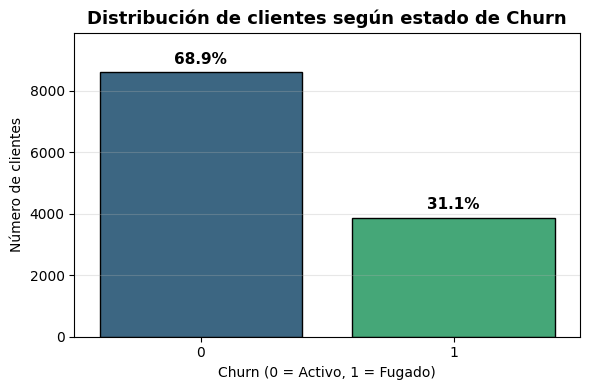

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular conteos y porcentajes
churn_stats = df_model['churn'].value_counts().to_frame('count')
churn_stats['percentage'] = df_model['churn'].value_counts(normalize=True) * 100

# Crear figura
plt.figure(figsize=(6, 4))
sns.barplot(
    x=churn_stats.index.astype(str),   # Aseguramos que las etiquetas aparezcan como texto
    y=churn_stats['count'],
    palette='viridis',
    edgecolor='black'
)

# Títulos y etiquetas
plt.title('Distribución de clientes según estado de Churn', fontsize=13, fontweight='bold')
plt.xlabel('Churn (0 = Activo, 1 = Fugado)')
plt.ylabel('Número de clientes')

# --- Etiquetas de porcentaje sobre cada barra ---
for i, (count, pct) in enumerate(zip(churn_stats['count'], churn_stats['percentage'])):
    plt.text(
        i, count + max(churn_stats['count']) * 0.02,  # +2% del valor máximo para despegar del borde
        f'{pct:.1f}%', ha='center', va='bottom',
        fontweight='bold', fontsize=11
    )

# Estilo visual
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(churn_stats['count']) * 1.15)  # margen superior 15%
plt.tight_layout()
plt.show()


## ANÁLISIS RELACIONAL VARIABLE CHURN 

In [157]:
df_model.columns

Index(['customer_key', 'last_order_date_obs', 'first_order_date_obs',
       'frequency', 'monetary', 'total_quantity', 'n_products', 'recency',
       'tenure_days', 'avg_order_value', 'items_per_order', 'orders_per_month',
       'recent_freq', 'recent_monetary', 'recent_quantity', 'High-Performer',
       'Low-Performer', 'Mid-Range', 'age_group', 'cust_segmentation',
       'avg_monthly_value', 'time_spam', 'churn'],
      dtype='object')

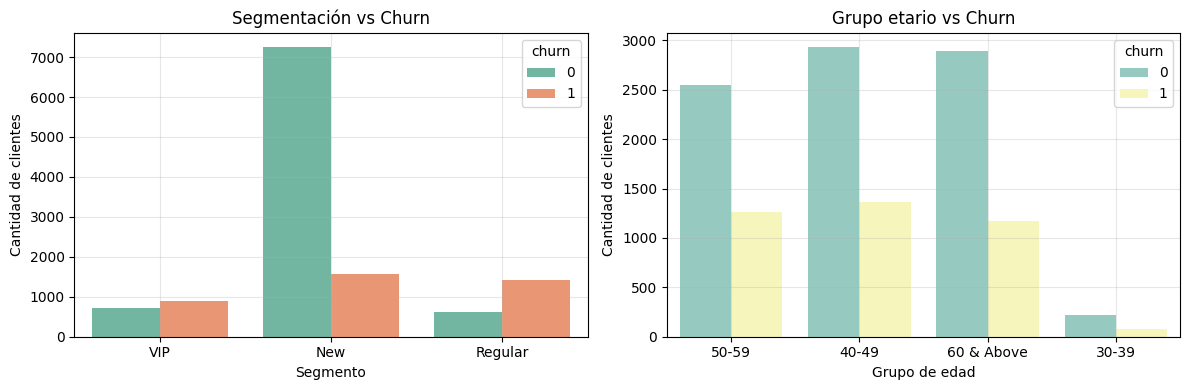

In [158]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(x='cust_segmentation', hue='churn', data=df_model, palette='Set2', ax=axes[0])
axes[0].set_title('Segmentación vs Churn')
axes[0].set_xlabel('Segmento')
axes[0].set_ylabel('Cantidad de clientes')
axes[0].grid(alpha=0.3)

sns.countplot(x='age_group', hue='churn', data=df_model, palette='Set3', ax=axes[1])
axes[1].set_title('Grupo etario vs Churn')
axes[1].set_xlabel('Grupo de edad')
axes[1].set_ylabel('Cantidad de clientes')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Relación entre recencia y ventas totales por cliente'}, xlabel='recency', ylabel='monetary'>

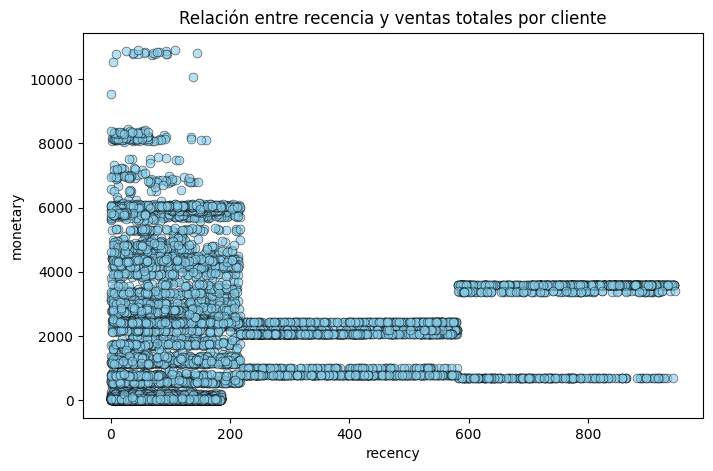

In [159]:
# --- Gráfico de dispersión ---
df_scatter = df_model[['recency', 'monetary', 'frequency']].dropna()

plt.figure(figsize=(8, 5))
plt.title('Relación entre recencia y ventas totales por cliente')
sns.scatterplot(
    data=df_scatter,
    x='recency',
    y='monetary',
    color='skyblue',
    edgecolor='black',
    alpha=0.6,
    s=40
)

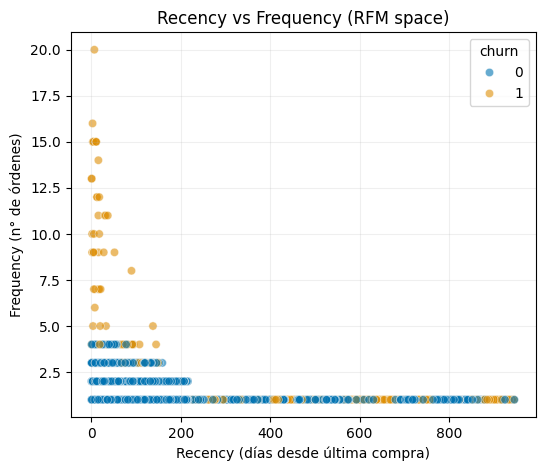

In [160]:
# Dispersión Recencia vs Frecuencia junto con Churn
plt.figure(figsize=(6,5))
sns.scatterplot(df_model, x='recency', y='frequency', hue='churn', palette='colorblind', alpha=0.6)
plt.title('Recency vs Frequency (RFM space)')
plt.xlabel('Recency (días desde última compra)')
plt.ylabel('Frequency (n° de órdenes)')
plt.grid(alpha=0.2)
plt.show()


## Curva de Pareto

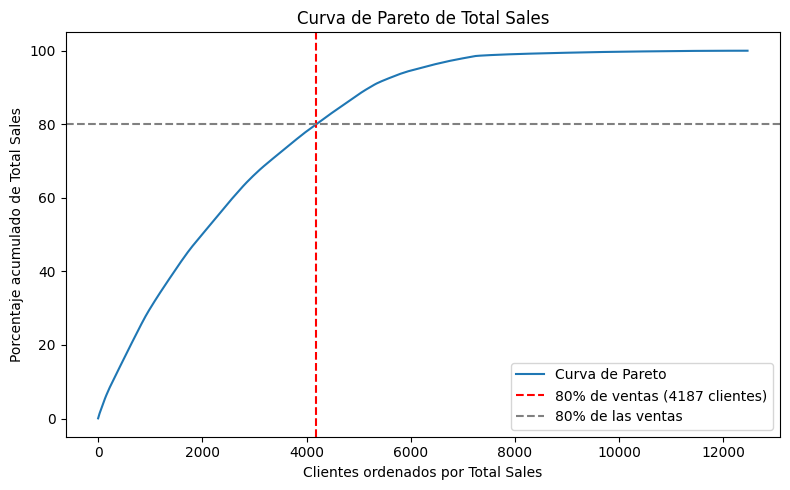

In [161]:
plt.figure(figsize=(8, 5))
sorted_sales = df_model['monetary'].dropna().sort_values(ascending=False).reset_index(drop=True)
cumulative_sales = sorted_sales.cumsum()
cumulative_percentage = cumulative_sales / cumulative_sales.iloc[-1] * 100
pareto_cutoff = (cumulative_percentage >= 80).idxmax()
plt.plot(cumulative_percentage, label='Curva de Pareto')
plt.axvline(x=pareto_cutoff, color='red', linestyle='--', label=f'80% de ventas ({pareto_cutoff} clientes)')
plt.axhline(y=80, color='gray', linestyle='--', label='80% de las ventas')
plt.title('Curva de Pareto de Total Sales')
plt.xlabel('Clientes ordenados por Total Sales')
plt.ylabel('Porcentaje acumulado de Total Sales')
plt.legend()
plt.tight_layout()
plt.show()

In [162]:
# Total de clientes considerados en el análisis
total_clientes = len(sorted_sales)

# Clientes que concentran el 80% de las ventas
clientes_80 = pareto_cutoff   # ya lo tienes calculado

# Porcentaje que representan
porcentaje_clientes = clientes_80 / total_clientes * 100

print(f"{clientes_80} clientes representan el {porcentaje_clientes:.2f}% del total de clientes")
print(f"Total de clientes: {total_clientes}")

4187 clientes representan el 33.59% del total de clientes
Total de clientes: 12466


In [163]:
df_model.dtypes

customer_key                     int64
last_order_date_obs     datetime64[ns]
first_order_date_obs    datetime64[ns]
frequency                        int64
monetary                         int64
total_quantity                   int64
n_products                       int64
recency                          int64
tenure_days                      int64
avg_order_value                float64
items_per_order                float64
orders_per_month               float64
recent_freq                    float64
recent_monetary                float64
recent_quantity                float64
High-Performer                 float64
Low-Performer                  float64
Mid-Range                      float64
age_group                       object
cust_segmentation               object
avg_monthly_value              float64
time_spam                        int64
churn                            int64
dtype: object

In [164]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Definir X e y
cols_drop = ["churn","orders_per_month","tenure_days", "frequency", "monetary", "recency", "customer_key", "last_order_date_obs",
             "first_order_date_obs", "avg_monthly_value", "recent_monetary", "recent_freq", "time_spam", "avg_order_value"]
X = df_model.drop(columns=cols_drop)
y = df_model["churn"]

# Separar tipos de variables
cat_cols = ["age_group", "cust_segmentation"]  # + las dummies de segmento ya son numéricas
num_cols = [c for c in X.columns if c not in cat_cols and c != "customer_key"]

# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Modelo simple
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf.fit(X_train, y_train)

# Predicciones
y_pred_lr = clf.predict(X_test)
y_prob_lr = clf.predict_proba(X_test)[:, 1]

print("\nDimension de los conjuntos de entrenamiento y prueba:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)




Dimension de los conjuntos de entrenamiento y prueba:
X_train: (9972, 9)
X_test: (2494, 9)
y_train: (9972,)
y_test: (2494,)


In [165]:
X.columns

Index(['total_quantity', 'n_products', 'items_per_order', 'recent_quantity',
       'High-Performer', 'Low-Performer', 'Mid-Range', 'age_group',
       'cust_segmentation'],
      dtype='object')

=== Métricas Regresión Logística (churn) ===
Accuracy : 0.8144
Precision: 0.7932
Recall   : 0.5445
F1-score : 0.6458
ROC-AUC  : 0.7991

Matriz de confusión:
                   Pred 0 (No churn)  Pred 1 (Churn)
Real 0 (No churn)               1609             110
Real 1 (Churn)                   353             422

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.82      0.94      0.87      1719
           1       0.79      0.54      0.65       775

    accuracy                           0.81      2494
   macro avg       0.81      0.74      0.76      2494
weighted avg       0.81      0.81      0.80      2494



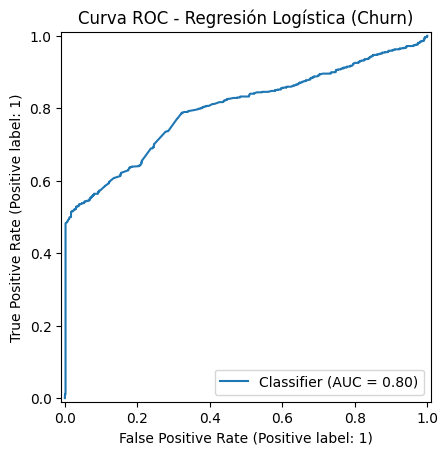

In [166]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)
import matplotlib.pyplot as plt
import pandas as pd

# ==========================
# 1) Predicciones y probabilidades
# ==========================
y_pred_log = clf.predict(X_test)
y_proba_log = clf.predict_proba(X_test)[:, 1]  # prob de churn = 1

# ==========================
# 2) Cálculo de métricas
# ==========================
acc  = accuracy_score(y_test, y_pred_log)
prec = precision_score(y_test, y_pred_log, zero_division=0)
rec  = recall_score(y_test, y_pred_log, zero_division=0)
f1   = f1_score(y_test, y_pred_log, zero_division=0)
auc  = roc_auc_score(y_test, y_proba_log)

print("=== Métricas Regresión Logística (churn) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")

# ==========================
# 3) Matriz de confusión
# ==========================
cm = confusion_matrix(y_test, y_pred_log)
cm_df = pd.DataFrame(
    cm,
    index=["Real 0 (No churn)", "Real 1 (Churn)"],
    columns=["Pred 0 (No churn)", "Pred 1 (Churn)"]
)

print("\nMatriz de confusión:")
print(cm_df)

# ==========================
# 4) Reporte de clasificación
# ==========================
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_log, zero_division=0))

# ==========================
# 5) Curva ROC (opcional pero muy útil)
# ==========================
RocCurveDisplay.from_predictions(y_test, y_proba_log)
plt.title("Curva ROC - Regresión Logística (Churn)")
plt.show()


# Ramdomm forest

In [167]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline de Random Forest reutilizando el mismo preprocesador
rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,        # nº de árboles
        max_depth=None,          # sin límite de profundidad (puedes tunear luego)
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1,               # usa todos los núcleos disponibles
        class_weight="balanced"  # útil si churn está desbalanceado
    ))
])

# Entrenar
rf_clf.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


=== Métricas Random Forest (Churn) ===
Accuracy : 0.8071
Precision: 0.6788
Recall   : 0.7200
F1-score : 0.6988
ROC-AUC  : 0.8673

Matriz de confusión:
                   Pred 0 (No churn)  Pred 1 (Churn)
Real 0 (No churn)               1455             264
Real 1 (Churn)                   217             558

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1719
           1       0.68      0.72      0.70       775

    accuracy                           0.81      2494
   macro avg       0.77      0.78      0.78      2494
weighted avg       0.81      0.81      0.81      2494



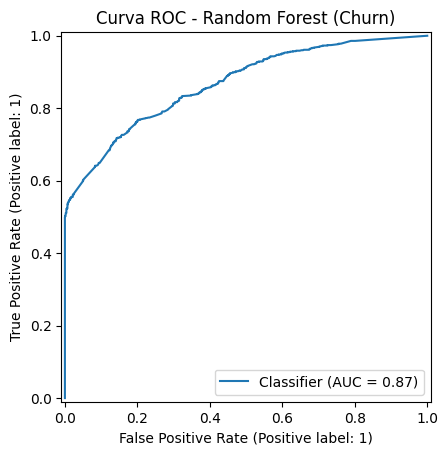

In [168]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)
import matplotlib.pyplot as plt
import pandas as pd

# Predicciones y probabilidades
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

print("=== Métricas Random Forest (Churn) ===")
print(f"Accuracy : {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf, zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_rf, zero_division=0):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred_rf, zero_division=0):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_proba_rf):.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(
    cm,
    index=["Real 0 (No churn)", "Real 1 (Churn)"],
    columns=["Pred 0 (No churn)", "Pred 1 (Churn)"]
)
print("\nMatriz de confusión:")
print(cm_df)

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# Curva ROC (opcional)
RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("Curva ROC - Random Forest (Churn)")
plt.show()


In [169]:
# Predicciones logística
y_pred_log = clf.predict(X_test)
y_proba_log = clf.predict_proba(X_test)[:, 1]

metrics_comparison = pd.DataFrame({
    "Modelo": ["Logística", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf)
    ],
    "Precision": [
        precision_score(y_test, y_pred_log, zero_division=0),
        precision_score(y_test, y_pred_rf, zero_division=0)
    ],
    "Recall": [
        recall_score(y_test, y_pred_log, zero_division=0),
        recall_score(y_test, y_pred_rf, zero_division=0)
    ],
    "F1-score": [
        f1_score(y_test, y_pred_log, zero_division=0),
        f1_score(y_test, y_pred_rf, zero_division=0)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_proba_log),
        roc_auc_score(y_test, y_proba_rf)
    ]
})

print("\n=== Comparación Logística vs Random Forest ===")
print(metrics_comparison)



=== Comparación Logística vs Random Forest ===
          Modelo  Accuracy  Precision    Recall  F1-score   ROC-AUC
0      Logística  0.814354   0.793233  0.544516  0.645754  0.799085
1  Random Forest  0.807137   0.678832  0.720000  0.698810  0.867252


# Variables importantes dentro del Ramdom Forest

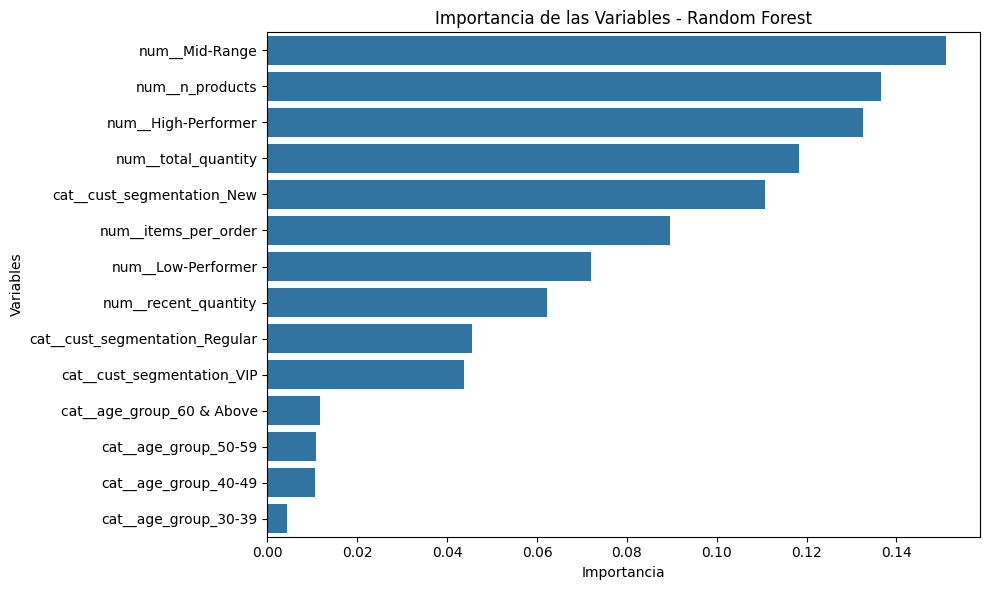

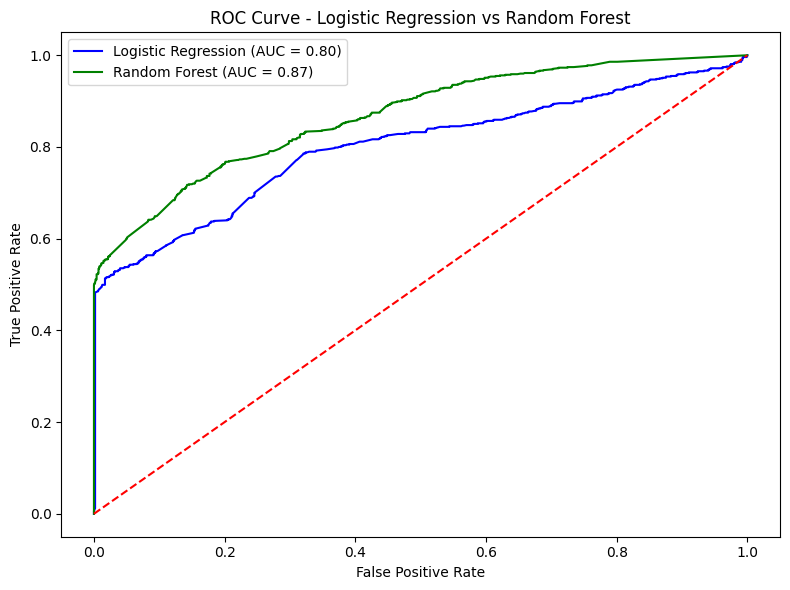

In [170]:
# ============================
# IMPORTANCIA DE VARIABLES RF
# ============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

importances = rf_clf.named_steps["model"].feature_importances_
feature_names = rf_clf.named_steps["preprocessor"].get_feature_names_out()

feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Importancia de las Variables - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()


# ============================
# ROC CURVE LR vs RF
# ============================
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue',  label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

plt.title('ROC Curve - Logistic Regression vs Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()


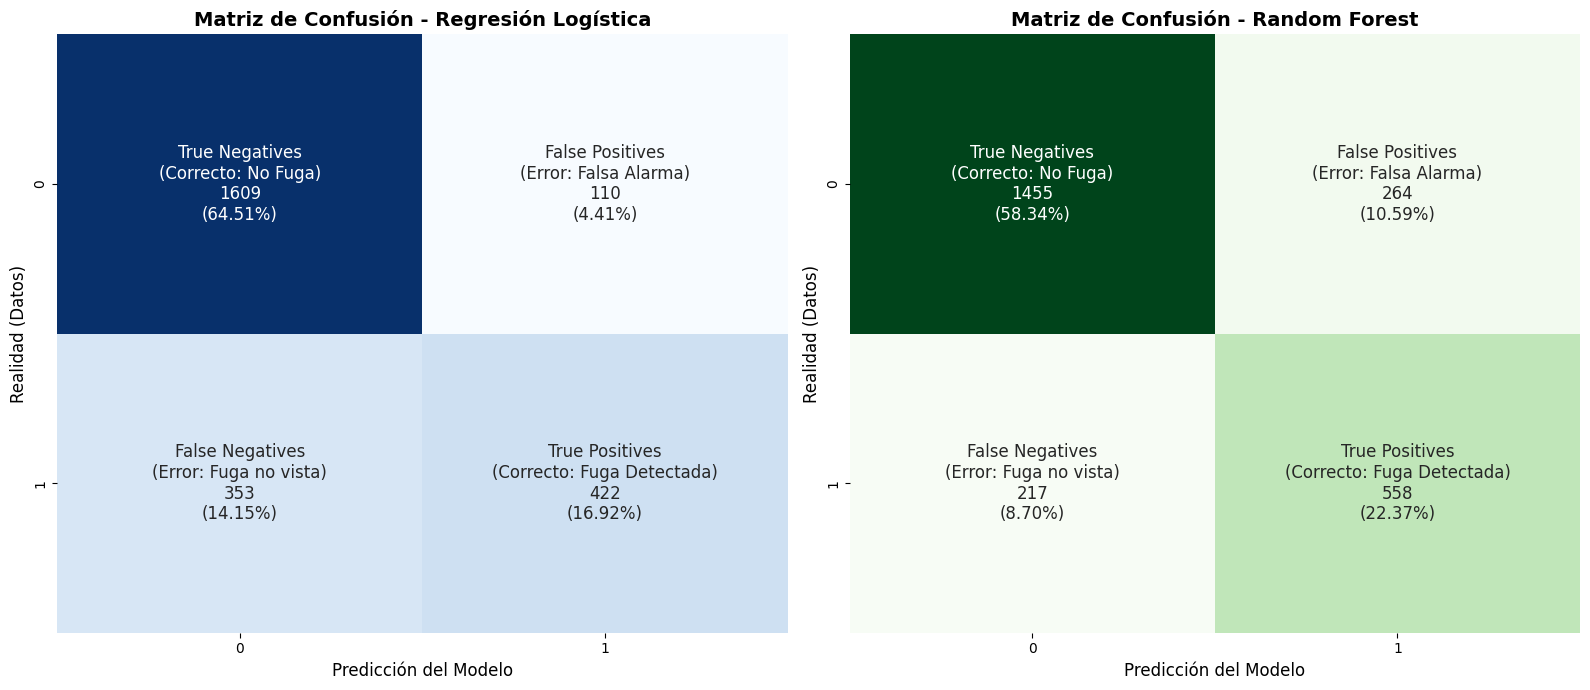

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_custom(y_test, y_pred, model_name, ax, cmap):
    # Calcular la matriz
    cm = confusion_matrix(y_test, y_pred)

    # Textos para cada cuadrante
    group_names = ['True Negatives\n(Correcto: No Fuga)', 'False Positives\n(Error: Falsa Alarma)',
                   'False Negatives\n(Error: Fuga no vista)', 'True Positives\n(Correcto: Fuga Detectada)']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

    # Combinar textos
    labels = [f"{v1}\n{v2}\n({v3})" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    # Graficar
    sns.heatmap(cm, annot=labels, fmt='', cmap=cmap, cbar=False, ax=ax, annot_kws={"size": 12})
    ax.set_title(f'Matriz de Confusión - {model_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicción del Modelo', fontsize=12)
    ax.set_ylabel('Realidad (Datos)', fontsize=12)

# Configurar el lienzo para dos gráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Graficar Regresión Logística (Azul)
plot_confusion_matrix_custom(y_test, y_pred_lr, "Regresión Logística", axes[0], 'Blues')

# Graficar Random Forest (Verde)
plot_confusion_matrix_custom(y_test, y_pred_rf, "Random Forest", axes[1], 'Greens')

plt.tight_layout()
plt.show()

In [171]:
df_model["avg_monthly_value"].mean()

np.float64(448.0058631477619)

In [172]:
## VALORIZACION
# DATOS PARA CALCULO
valor_mensual = 448
meses_retencion = 6
costo_accion = 10
tasa_exito = 0.5

# VALOR TOTAL DE RESCATAR A UN CLIENTE
valor_cliente_rescatado = valor_mensual * meses_retencion
print("Valor total a rescatar a un cliente:", valor_cliente_rescatado, "USD")

# DATOS MATRIZ DE CONFUNSION
# RL
tp_lr = 422 # Aciertos (True Positive)
fp_lr = 110 # Falsa alarma (False Positive)

# RF
tp_rf = 558 # Aciertos (True Positive)
fp_rf = 264 # Falsa alarma (False Positive)

def calcular_beneficio(tp, fp):
  #Dinero ganado: (clientes reales * % exito * valor)
  ganancia = tp * tasa_exito * valor_cliente_rescatado
  # Dinero gastado: (Total llamadas * costo por llamar)
  costo = (tp + fp) * costo_accion
  return ganancia - costo

# Calcular
neto_lr = calcular_beneficio(tp_lr, fp_lr)
neto_rf = calcular_beneficio(tp_rf, fp_rf)


Valor total a rescatar a un cliente: 2688 USD


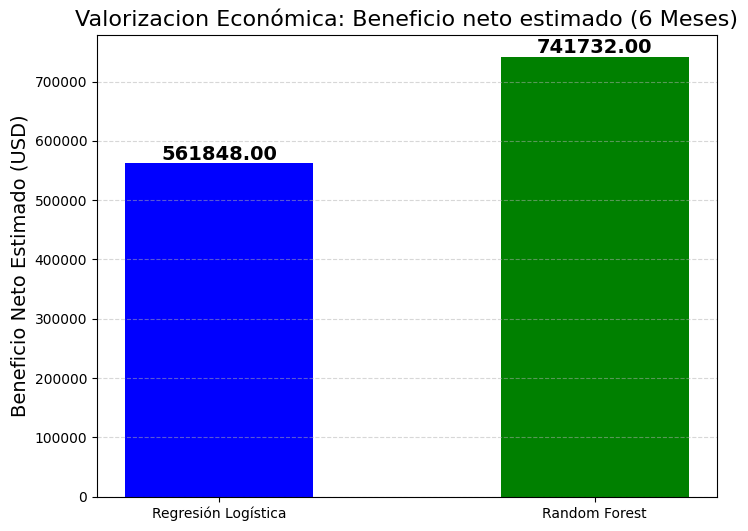

In [173]:
# Graficar modelos

modelos = ['Regresión Logística', 'Random Forest']
beneficios = [neto_lr, neto_rf]
colores = ['blue', 'green']

plt.figure(figsize=(8, 6))
barras = plt.bar(modelos, beneficios, color=colores, width = 0.5)

for rect in barras:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom',
             fontsize = 14, fontweight = "bold")

plt.title(f'Valorizacion Económica: Beneficio neto estimado ({meses_retencion} Meses)', fontsize =16)
plt.ylabel('Beneficio Neto Estimado (USD)', fontsize = 14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [174]:
# Suponemos que ya tienes:
# - df            -> dataframe completo con datos de clientes
# - X_train, X_test, y_train, y_test
# - y_proba_log   -> clf.predict_proba(X_test)[:, 1]
# - y_proba_rf    -> rf_clf.predict_proba(X_test)[:, 1]
df_tabla_proba_churn = df_model.copy()
df_tabla_proba_churn = df_model.merge(
    df_clientes[['customer_key', 'customer_name', 'customer_number']],
    on='customer_key',
    how='left' )


cols_pct = ["High-Performer", "Mid-Range", "Low-Performer"]
cols_pct = [c for c in cols_pct if c in df_tabla_proba_churn.columns]

df_tabla_proba_churn[cols_pct] = df_tabla_proba_churn[cols_pct] * 100
df_tabla_proba_churn = df_tabla_proba_churn.rename(columns={
    "High-Performer": "High-Performer(%)",
    "Mid-Range": "Mid-Range(%)",
    "Low-Performer": "Low-Performer(%)"
})
# 1) Recuperar la info completa de los clientes del set de test
#    (usando los índices de X_test para que calce fila a fila)
X_test_con_nombres = df_tabla_proba_churn.loc[X_test.index].copy()

# 2) Definir las columnas descriptivas que quieres ver
cols_info = ['customer_name', 'avg_monthly_value', 'tenure_days',
             'cust_segmentation', 'age_group', "High-Performer(%)", "Low-Performer(%)", "Mid-Range(%)", "items_per_order"]

# 3) Construir tabla de resultados con ambas probabilidades
resultados = X_test_con_nombres[cols_info].copy()
resultados['Probabilidad_Fuga_Log'] = y_proba_log
resultados['Probabilidad_Fuga_RF'] = y_proba_rf

from IPython.display import display

display(resultados.sort_values(by='Probabilidad_Fuga_RF', ascending=False).head(25))


,customer_name,avg_monthly_value,tenure_days,cust_segmentation,age_group,High-Performer(%),Low-Performer(%),Mid-Range(%),items_per_order,Probabilidad_Fuga_Log,Probabilidad_Fuga_RF
1481,Alexandra Richardson,312.05,587,VIP,50-59,100.0,0.0,0.0,1.0,0.836449,1.0
9320,Lee Dominguez,334.17,237,Regular,40-49,100.0,0.0,0.0,1.0,0.799264,1.0
8894,Lori Sanz,222.36,639,Regular,40-49,100.0,0.0,0.0,1.0,0.799264,1.0
10260,Connor King,303.58,591,VIP,50-59,100.0,0.0,0.0,1.0,0.836449,1.0
5298,Louis Zhou,163.86,846,Regular,40-49,100.0,0.0,0.0,1.0,0.799264,1.0
11542,Amanda Wood,182.45,907,VIP,50-59,100.0,0.0,0.0,1.0,0.836449,1.0
4209,Diana Navarro,551.54,310,VIP,40-49,100.0,0.0,0.0,1.0,0.823943,1.0
7444,Alexis Patterson,292.80,334,Regular,60 & Above,100.0,0.0,0.0,1.0,0.782477,1.0
3564,Nathan Robinson,224.64,438,Regular,50-59,100.0,0.0,0.0,1.0,0.813125,1.0
6101,Charles Baker,149.00,400,Regular,50-59,100.0,0.0,0.0,1.0,0.813125,1.0


C:\Users\jdcha\AppData\Local\Temp\ipykernel_32636\1523163087.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Peso", y="Variable", data=df_coef.head(10), palette="coolwarm")


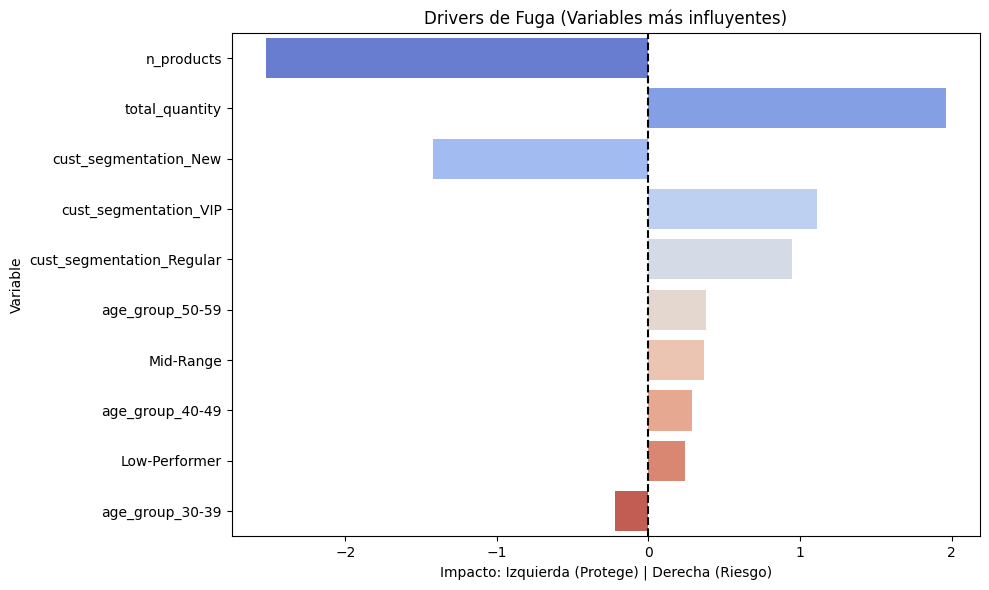

In [175]:
# 2- ¿Qué características presentan esos clientes? Respuesta:

try:
    # 1) Obtener nombres de features categóricas ya one-hot encodeadas
    feature_names_cat = clf.named_steps["preprocessor"] \
                           .named_transformers_["cat"] \
                           .get_feature_names_out(cat_cols)

    # 2) Juntar numéricas originales + categóricas codificadas
    todos_los_features = num_cols + list(feature_names_cat)

    # 3) Extraer coeficientes del modelo logístico
    coeficientes = clf.named_steps["model"].coef_[0]

    # 4) DataFrame ordenado por magnitud del coeficiente
    df_coef = pd.DataFrame({
        "Variable": todos_los_features,
        "Peso": coeficientes
    })
    df_coef = df_coef.reindex(df_coef["Peso"].abs().sort_values(ascending=False).index)

    # 5) Gráfico de las 10 variables más influyentes
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Peso", y="Variable", data=df_coef.head(10), palette="coolwarm")
    plt.title("Drivers de Fuga (Variables más influyentes)")
    plt.axvline(0, color="black", linestyle="--")
    plt.xlabel("Impacto: Izquierda (Protege) | Derecha (Riesgo)")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")
